# Imports

In [0]:
import pandas as pd
import numpy as np
import tensorflow.compat.v2 as tf 
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sb

tf.version.VERSION

In [0]:
# Function to show train history

def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

## Load data
### Train data

In [4]:
path = "../data/AmazonTrainSet1M.tsv"
amazonData = pd.read_csv(path, sep='\t', header=0, encoding="utf-8")
row_sizes = amazonData['SentimentText'].str.split().str.len()
amazonData['SentimentText'] = amazonData['SentimentText'].str.lower()
print(f"Words count: {pd.Series.sum(row_sizes)}")
amazonData

Words count: 78450202


,Sentiment,SentimentText
0,0,defective: i was really excited to get the fis...
1,1,m-audio 2496 sound card: excellent sound card ...
2,0,missing links: it's a shame the quality of thi...
3,0,tribute album: this is a tribute album...i did...
4,1,pretty good: it does taste pretty good and is ...
...,...,...
999995,1,tlc...... need i say more: tlc is the best gro...
999996,1,alternative ending: an excellent book no doubt...
999997,1,p-town series: i read these out of order becau...
999998,0,pretty sad....: this book would play out bette...


### Test data

In [5]:
path = "../data/AmazonTestSet400k2.tsv"
testData = pd.read_csv(path, sep='\t', header=0, encoding="utf-8")
row_sizes = testData['SentimentText'].str.split().str.len()
testData['SentimentText'] = testData['SentimentText'].str.lower()
print(f"Words count: {pd.Series.sum(row_sizes)}")
testData


Words count: 31369658


,Sentiment,SentimentText
0,1,this is a great book: i must preface this by s...
1,0,"huge disappointment.: as a big time, long term..."
2,1,wayne is tight but cant hang with turk.: this ...
3,1,excellent: i read this book when i was in elem...
4,0,not about anusara: although this book is toute...
...,...,...
399995,0,you can fool all the people some of the time b...
399996,0,it was good but not good: it was an 'okay' boo...
399997,0,unwatchable: the product arrived promptly and ...
399998,0,not worth the money or the time to read.: the ...


### Validation data

In [6]:
path = "../data/AmazonValidationSet100K.tsv"
validation_data = pd.read_csv(path, sep='\t', header=0, encoding="utf-8") # , quoting=csv.QUOTE_NONE
row_sizes = validation_data['SentimentText'].str.split().str.len()
validation_data['SentimentText'] = validation_data['SentimentText'].str.lower()
print(f"Words count: {pd.Series.sum(row_sizes)}")
validation_data

Words count: 7826428


,Sentiment,SentimentText
0,0,just another political opinion disguised as hi...
1,0,the big bad maniac magee review: i did not lik...
2,1,a good cable: the cable does exactly what it i...
3,0,it stinks!: it's so bad it should come with a ...
4,0,do women really take this seriously?: i picked...
...,...,...
99995,1,nice surprise: expecting this older mystery to...
99996,0,huh?: i fail to see the purpose of this book. ...
99997,0,don't buy this cirque du (school)!: i love cir...
99998,1,"soft-edged, just a bit undercharacterized: bou..."


## Preprocessing

In [0]:
df = amazonData
df['review_lenght'] = np.array(list(map(lambda x: len(x.split()), df['SentimentText'])))
median = df['review_lenght'].median()
mean = df['review_lenght'].mean()
_max_length = df['review_lenght'].max()

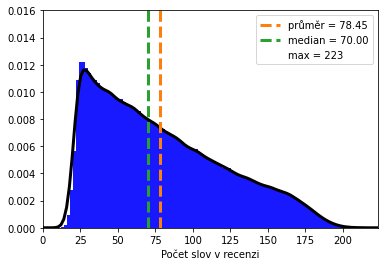

In [11]:
fig, ax = plt.subplots()
sb.distplot( df['review_lenght'],  bins=int(_max_length/2),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=_max_length)
ax.set_xlabel('Počet slov v recenzi')
ymax = 0.016
plt.ylim(0, ymax)
ax.plot([mean, mean], [0, ymax], '--', label=f'průměr = {mean:.2f}', linewidth=3)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=3)
ax.plot([_max_length, _max_length], [0, ymax], '--', label=f'max = {_max_length}', linewidth=0)
# ax.set_title('Distribuce slov v recenzích', fontsize=20)
plt.legend()
plt.show()

In [12]:
# Tokenizing and padding
## Train data
max_dictionary_size = 10000
tokenizer = Tokenizer(num_words=max_dictionary_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(df['SentimentText'])
list_tokenized_train = tokenizer.texts_to_sequences(df['SentimentText'])
max_length = 180
X_t = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
y = amazonData['Sentiment']
print("Max dictionary size")
len(tokenizer.index_word)

Max dictionary size


502158

In [0]:
## Test data
list_tokenized_train = tokenizer.texts_to_sequences(testData['SentimentText'])
X_test = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
y_test = testData['Sentiment']

In [0]:
## Validation data
list_tokenized_train = tokenizer.texts_to_sequences(validation_data['SentimentText'])
X_valid = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
y_valid = validation_data['Sentiment']

## LSTM

In [15]:
## Create model
model = keras.models.Sequential([
    keras.layers.Embedding(max_dictionary_size, 16, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True)),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(16),
    keras.layers.Dense(1, activation="sigmoid")                                
])

model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=4,
                                        verbose=1,
                                        mode='auto',
                                        restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 180, 32)           4224      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 164,769
Trainable params: 164,769
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
7813/7813 [==============================] - 188s 24ms/step - loss: 0.2046 - accuracy: 0.9185 - val_loss: 0.1652 - val_accuracy: 0.9365
Epoch 2/12
7813/7813 [==============================] - 189s 24ms/step - loss: 0.1547 - accuracy: 0.9414 - val_loss: 0.1546 - val_accuracy: 0.9409
Epoch 3/12
7813/7813 [==============================] - 191s 24ms/step - loss: 0.1393 - accuracy: 0.9483 - val_loss: 0.1538 - val_accuracy: 0.9412
Epoch 4/12
7813/7813 [==============================] - 189s 24ms/step - loss: 0.1287 - accuracy: 0.9527 - val_loss: 0.1555 - val_accuracy: 0.9421
Epoch 5/12
7813/7813 [==============================] - 190s 24ms/step - loss: 0.1202 - accuracy: 0.9565 - val_loss: 0.1544 - val_accuracy: 0.9421
Epoch 6/12
7813/7813 [==============================] - 191s 24ms/step - loss: 0.1128 - accuracy: 0.9595 - val_loss: 0.1571 - val_accuracy: 0.9424
Epoch 7/12
7813/7813 [==============================] - 192s 25ms/step - loss: 0.1062 - accuracy: 0.9623 - val_loss: 0

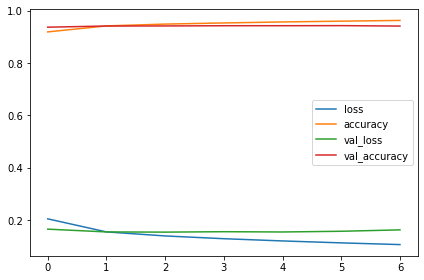

In [16]:
## Train model
history = model.fit(X_t,y, batch_size=128, epochs=12, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
show_history(history)

In [17]:
## Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: ', test_acc)

12500/12500 [==============================] - 118s 9ms/step - loss: 0.1559 - accuracy: 0.9409
Test accuracy:  0.9409375190734863


## CNN

In [18]:
## Create model

filters = 64
kernel_size = 3

model = keras.models.Sequential([
    keras.layers.Embedding(max_dictionary_size, 16, input_length=max_length),
    keras.layers.Conv1D(filters, kernel_size, activation="relu"),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(64),
    keras.layers.Activation("relu"),
    keras.layers.Dense(1, activation="sigmoid")                                
])

model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=3,
                                        verbose=1,
                                        mode='auto',
                                        restore_best_weights=True)
                                        

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 178, 64)           3136      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 167,361
Trainable params: 167,361
Non-trainable params: 0
________________________________________________

Epoch 1/12
7813/7813 [==============================] - 68s 9ms/step - loss: 0.2141 - accuracy: 0.9136 - val_loss: 0.1828 - val_accuracy: 0.9293
Epoch 2/12
7813/7813 [==============================] - 68s 9ms/step - loss: 0.1686 - accuracy: 0.9357 - val_loss: 0.1769 - val_accuracy: 0.9320
Epoch 3/12
7813/7813 [==============================] - 67s 9ms/step - loss: 0.1529 - accuracy: 0.9424 - val_loss: 0.1772 - val_accuracy: 0.9323
Epoch 4/12
7813/7813 [==============================] - 67s 9ms/step - loss: 0.1413 - accuracy: 0.9478 - val_loss: 0.1786 - val_accuracy: 0.9315
Epoch 5/12
7813/7813 [==============================] - 66s 8ms/step - loss: 0.1318 - accuracy: 0.9521 - val_loss: 0.1805 - val_accuracy: 0.9312
Epoch 00005: early stopping


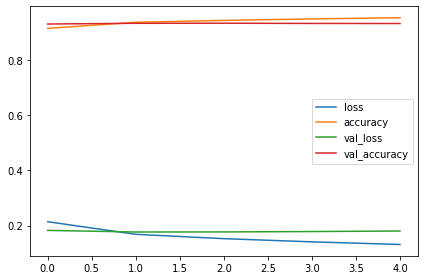

In [19]:
## Train model
history = model.fit(X_t,y, batch_size=128, epochs=12, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
show_history(history)

In [20]:
## Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: ', test_acc)

12500/12500 [==============================] - 36s 3ms/step - loss: 0.1806 - accuracy: 0.9309
Test accuracy:  0.9308900237083435
